In [1]:
#https://mode.com/example-gallery/python_dataframe_styling/

#bibliothèque
import plotly.express as px
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from sklearn.metrics import r2_score
# Fonction pour changer la couleur du texte
def couleur(valeur):
    if valeur < 0:
        return f'<font color="red">{valeur}</font>'
    else:
        return f'<font color="green">{valeur}</font>'

Pour obtenir une liste avec tout les tags des entreprises du CAC40 :

In [299]:
# Chemin du dossier
dossier = "data-fr/Data_CAC40"
fichiers = os.listdir(dossier)
list_tags = []
for i in fichiers:
    chaine = i
    chaine_sans_dataframe = chaine.replace("dataframe_", "")
    second = chaine_sans_dataframe.replace(".csv","")
    list_tags.append(second)

print(list_tags)
list_tags = ['SU.PA', 'ORA.PA', 'ACA.PA', 'STM.PA', 'CAP.PA', 'DSY.PA', 'MC.PA', 'MT.AS', 'RI.PA', 'ENGI.PA', 'KER.PA', 'BN.PA', 'LR.PA', 'BNP.PA', '^FCHI', 'AIR.PA', 'SAN.PA', 'SGO.PA', 'GLE.PA', 'OR.PA', 'ML.PA', 'CA.PA', 'SAF.PA', 'AI.PA']


['SU.PA', 'ORA.PA', 'ACA.PA', 'STM.PA', 'CAP.PA', 'DSY.PA', 'MC.PA', 'MT.AS', 'RI.PA', 'ENGI.PA', 'KER.PA', 'BN.PA', 'LR.PA', 'BNP.PA', '^FCHI', 'AIR.PA', 'SAN.PA', 'SGO.PA', 'GLE.PA', 'OR.PA', 'ML.PA', 'CA.PA', 'SAF.PA', 'AI.PA']


Class portefeuille d'action:

In [300]:
class portefeuille:
    def __init__(self, noms_titres, quantites, time_achat) -> None:
        self.noms_titres = noms_titres
        self.quantites = quantites
        self.time = time_achat
        #On importe les données
        self.data = []
        self.prix = []
        for i in self.noms_titres:
            path = "data-fr/Data_CAC40/dataframe_"+i+".csv"
            df = pd.read_csv(path)
            self.data.append(df)
            #print(i, "chargé")
        #On récupère le prix de fermeture des actions à l'instant t = time_achat
        self.recuperer_prix(self.time)
        #Création du dataframe de notre portefeuille
        self.complete_actions_df()
    

    def __str__(self) -> str:
        return f'{self.actions}'
    
    def get_noms_titres(self):
        return self.noms_titres

    def recuperer_prix(self, t):
        for i in self.data:
            self.prix.append(i['Close'][t])

            
    def get_data(self):
        return self.data
    
    def complete_actions_df(self):
        self.actions_temp = {'Prix achat à t = ' + str(self.time) :self.prix,
                        'Quantite': self.quantites}
        self.actions = pd.DataFrame(self.actions_temp, index=self.noms_titres)
        self.actions['Valeur des actions en $'] = self.actions.apply(lambda row: row['Prix achat à t = ' + str(self.time)] * row['Quantite'], axis=1)

    def add_predic(self, t, mod):
            predict = []
            for i in mod.models:
                predict.append(i.predict(np.array([t]).reshape(1,1))[0])
            self.actions['Évolution du prix en %'] = 100*(predict-self.actions['Prix achat à t = ' + str(self.time)])/self.actions['Prix achat à t = ' + str(self.time)]
            self.actions['Estimation du prix de unitaire à t = '+str(t)] = predict
            self.actions['Estimation de la valeur des actions à t = '+str(t)] = self.actions.apply(lambda row: row['Estimation du prix de unitaire à t = '+str(t)] * row['Quantite'], axis=1)
            #self.couleur_evolution()
            self.actions['Coefficient de determination'] = self.scores

    def afficher_resultats(self):
        return self.actions.head(len(self.actions))
    
    def couleur_evolution(self):
        self.actions['Évolution du prix en %'] = self.actions['Évolution du prix en %'].apply(lambda x: couleur(x))

    def get_r2_mean(self):
        return self.actions['Coefficient de determination'].mean()
    
    def get_r2_var(self):
        return self.actions['Coefficient de determination'].var()

    def set_scores(self, scores):
        self.scores = scores

### Les models

In [301]:
class lr_models:
    #period = période d'apprentissage => inputs
    def __init__(self, portefeuille, period, learning_rate) -> None:
        self.mon_portefeuille = portefeuille 
        self.noms_titres = portefeuille.get_noms_titres()
        self.m = period
        self.learning_rate = learning_rate
        self.scores = []

    def create_models(self):
        self.models = []
        for i in self.mon_portefeuille.get_data():
            self.models.append(self.get_model(i))


    def get_model(self, df_titre):
        df = df_titre.head(self.m)
        self.Y = df['Close']
        self.X = np.arange(self.m).reshape(self.m,1)
        model = LinearRegression()
        model.fit(self.X,self.Y)
        self.scores.append(model.score(self.X,self.Y))
        self.mon_portefeuille.set_scores(self.scores)
        #print(model.score(self.X, self.Y))
        return model


In [357]:
#Quelles actions on veut dans notre portefeuille d'actions et quelles sont les quantités? 
liste_tags_entreprises = list_tags
quantites = [random.randint(1, 10) for _ in range(len(liste_tags_entreprises))]
buy_order = 0
time_target = 2800 #Pour quand on souhaite effectuer des prédictions
#Paramètres de l'apprentissage :
learning_period = 1000
learning_rate = 0.01

Création de mon portefeuille, et de mes modèles d'apprentissages + Ajouts des prédictions

In [358]:
portefeuille_maxime = portefeuille(liste_tags_entreprises,quantites, buy_order)
model = lr_models(portefeuille_maxime, learning_period, learning_rate)
model.create_models()
portefeuille_maxime.add_predic(time_target,model)

In [359]:
portefeuille_maxime.add_predic(time_target,model)

In [360]:
portefeuille_maxime.actions.head(len(portefeuille_maxime.actions))

,Prix achat à t = 0,Quantite,Valeur des actions en $,Évolution du prix en %,Estimation du prix de unitaire à t = 2800,Estimation de la valeur des actions à t = 2800,Coefficient de determination
SU.PA,29.081612,9,261.734505,155.126121,74.194788,667.753089,0.492797
ORA.PA,7.673621,8,61.388966,-111.622308,-0.891852,-7.134814,0.734550
ACA.PA,7.259819,5,36.299093,-131.922317,-2.317502,-11.587511,0.300517
STM.PA,3.978039,6,23.868231,24.455342,4.950881,29.705289,0.013205
CAP.PA,25.837217,3,77.511652,62.480800,41.980517,125.941552,0.121019
DSY.PA,3.705438,7,25.938064,418.503749,19.212833,134.489832,0.925055
MC.PA,60.678326,2,121.356651,246.060883,209.983950,419.967899,0.837816
MT.AS,53.427956,2,106.855911,-189.362354,-47.744479,-95.488957,0.803692
RI.PA,47.699757,2,95.399513,205.814636,145.872837,291.745674,0.867940
ENGI.PA,12.153281,5,60.766406,-94.479303,0.670946,3.354729,0.601582


### Rentabilité du portefeuille


In [361]:
df = portefeuille_maxime.actions

In [362]:
total_temps_buy_order = df['Valeur des actions en $'].sum()
print("Valeur de mon portefeuille : " , total_temps_buy_order)

Valeur de mon portefeuille :  7055.6267375946045


In [363]:
total_temps_target = df['Estimation de la valeur des actions à t = '+str(time_target)].sum()
print("Valeur de mon portefeuille estimé : " , total_temps_target)

Valeur de mon portefeuille estimé :  10969.556786125153


In [364]:
print("Gain estimé : ", total_temps_target-total_temps_buy_order)

Gain estimé :  3913.9300485305484


In [356]:
print(df['Coefficient de determination'].mean())

0.6733857377124082


In [318]:
def r2_mean_var(liste_tags_entreprises, quantites,learning_rate,time_target,buy_order, nit): 
    if nit > 100 :
        r2_mean_hist = []
        r2_var_hist = []
        for i in range(100, nit + 100):
            p = portefeuille(liste_tags_entreprises, quantites, buy_order)
            model = lr_models(p, i, learning_rate)
            model.create_models()
            p.add_predic(time_target, model)
            r2_mean_hist.append(p.get_r2_mean())
            r2_var_hist.append(p.get_r2_var())
            print(i)
        return range(100, nit + 100), r2_mean_hist, r2_var_hist
    else : print("Merci de choisir un n_itération > 100 ")

### Évolution de la moyenne du coefficient de détermination en fonction la période d'apprentissage

On va considerer un portefeuille aleatoiremement définit par la variable <code>quantities</code> on conserve également le <code>learning_rate</code> de <b> 0.01 </b>

In [319]:
quantites = [random.randint(1, 10) for _ in range(len(liste_tags_entreprises))]
buy_order = 0
time_target = 200 #Pour quand on souhaite effectuer des prédictions
#Paramètres de l'apprentissage :
learning_period = 100
learning_rate = 0.01

In [320]:
x , y_m, y_v = r2_mean_var(liste_tags_entreprises, quantites, learning_rate, 2800,0, 2700)

In [339]:
fig = px.line(x=x, y= y_m, labels={'x':'Taille en jours de la période d apprentissage', 'y':' Moyenne du coefficient de determination'})
fig.show()

In [340]:
fig = px.line(x=x, y= y_v, labels={'x':'Taille en jours de la période d apprentissage ', 'y':' Variance du coefficient de determination'})
fig.show()

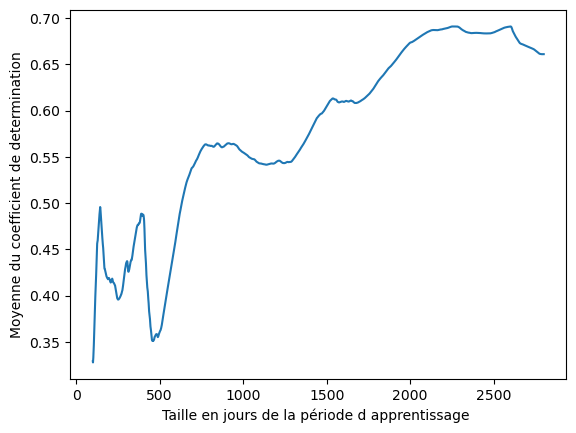

In [346]:
plt.plot(x, y_m)
plt.ylabel('Moyenne du coefficient de determination')
plt.xlabel('Taille en jours de la période d apprentissage ')
plt.show()

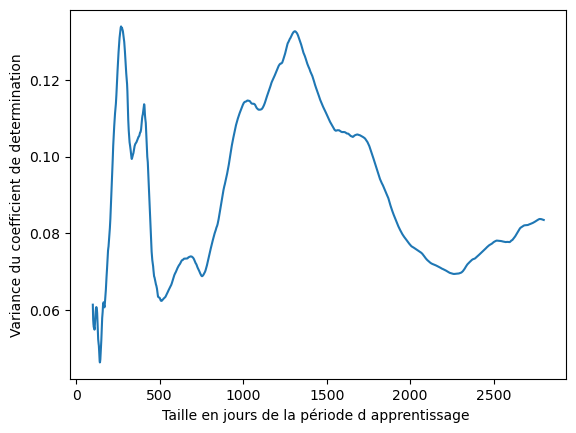

In [345]:
plt.plot(x,y_v)
plt.ylabel('Variance du coefficient de determination')
plt.xlabel('Taille en jours de la période d apprentissage ')
plt.show()